<a href="https://colab.research.google.com/github/poponzu/Research/blob/master/LSTM%E3%81%AB%E3%81%8F%E3%81%A3%E3%81%A4%E3%81%91%E3%82%8B%E3%82%88%E3%81%86%E3%81%AESequitur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
# Standard Library
from statistics import mean

# Third Party
import torch
from torch.nn import MSELoss
import tqdm
import random
import os
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

## LSTM-AE

## quick_train.py

In [2]:
# seed決定するためのコード
def seed_everything(seed=42):
    print('Setting Random Seed')
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

Setting Random Seed


## train.py

In [3]:
# Google Driveをマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LSTM-AE/Bike_sharing_predict/Bike-Sharing-Dataset/hour.csv")

In [5]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [6]:
Bike_data = data[['cnt', 'temp', 'registered']]
# Bike_data = data[['temp', 'registered']]

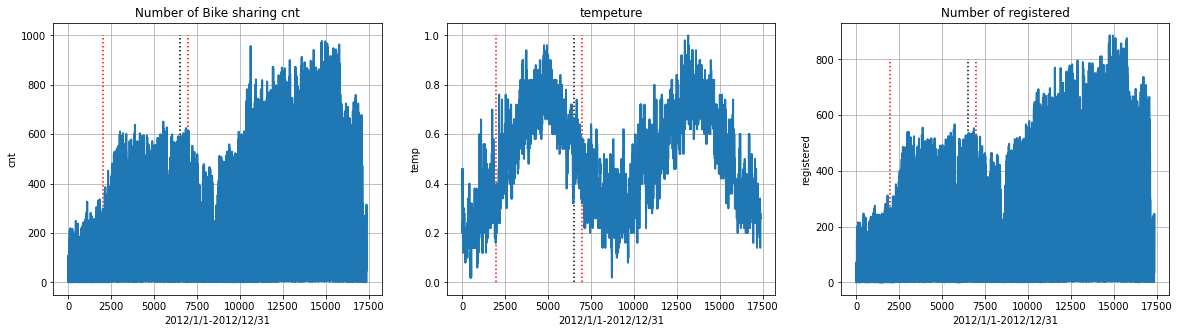

In [7]:
fig, (axL, axM, axR) = plt.subplots(ncols=3, figsize=(20,5))

axL.plot(Bike_data['cnt'], linewidth=2)
axL.set_title('Number of Bike sharing cnt')
axL.set_xlabel('2012/1/1-2012/12/31')
axL.set_ylabel('cnt')
axL.grid(True)
axL.vlines(x=2000, ymin=0, ymax=1000, colors='red', linestyles='dotted')
axL.vlines(x=6500, ymin=0, ymax=1000, colors='black', linestyles='dotted')
axL.vlines(x=7000, ymin=0, ymax=1000, colors='red', linestyles='dotted')


axM.plot(Bike_data['temp'], linewidth=2)
axM.set_title('tempeture')
axM.set_xlabel('2012/1/1-2012/12/31')
axM.set_ylabel('temp')
axM.grid(True)
axM.vlines(x=2000, ymin=0, ymax=1, colors='red', linestyles='dotted')
axM.vlines(x=6500, ymin=0, ymax=1, colors='black', linestyles='dotted')
axM.vlines(x=7000, ymin=0, ymax=1, colors='red', linestyles='dotted')

axR.plot(Bike_data['registered'], linewidth=2)
axR.set_title('Number of registered')
axR.set_xlabel('2012/1/1-2012/12/31')
axR.set_ylabel('registered')
axR.grid(True)
axR.vlines(x=2000, ymin=0, ymax=800, colors='red', linestyles='dotted')
axR.vlines(x=6500, ymin=0, ymax=800, colors='black', linestyles='dotted')
axR.vlines(x=7000, ymin=0, ymax=800, colors='red', linestyles='dotted')

fig.show()

In [8]:
# データ量を調節
Bike_data = Bike_data[2000:7000]

In [9]:
Bike_data = Bike_data.values.astype(float)
Bike_data.shape

(5000, 3)

In [10]:
BIke_data = torch.from_numpy(Bike_data)

In [11]:
train_data_size = 4500
test_data_size = 500

train_data = Bike_data[:-test_data_size]
test_data = Bike_data[-test_data_size:]

In [12]:
#train_dataの正規化
# データセットの正規化を行う。最小値0と最大値1の範囲で行う。
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data)

In [13]:
# Tensor型に変換
train_data_normalized = torch.FloatTensor(train_data_normalized)

## こっからAEでは不必要だと思う

In [14]:
# シーケンスに沿ったデータを作成する関数
def make_sequence_data(input_data, num_sequence):
    # シーケンスデータとラベルデータの器
    data = []
    # 全体のデータ数取得
    num_data = len(input_data)
    # 全体からシーケンス分引いた数までループする
    for i in range(num_data - num_sequence):
        # 1個ずらして、シーケンス分のデータを取得していく
        seq_data = input_data[i:i+num_sequence]
        # シーケンスの次の要素のデータ(ラベルデータとして1個目の陽性者数のみ)を取得していく
        target_data = input_data[:,0][i+num_sequence:i+num_sequence+1]
        # シーケンスデータとラベルデータをタプルとして取得していく
        data.append((seq_data, target_data))

    return data

In [15]:
# シーケンス長は24データとする
# 24時間分のデータから次の1日後のデータを予測する
# 48時間とかにしてもよいかも
seq_length = 24
# train_seq_data=最初のデータを1個ずらしてシーケンス分のデータ(時系列の学習データ群)、train_target=train_seq_dataの次のデータ(ラベルデータ)
train_seq_data = make_sequence_data(train_data_normalized, seq_length)

## モデル作成

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, out_dim, h_dims, h_activ, out_activ):
        super(Encoder, self).__init__()

        layer_dims = [input_dim] + h_dims + [out_dim]
        self.num_layers = len(layer_dims) - 1
        self.layers = nn.ModuleList()
        for index in range(self.num_layers):
            layer = nn.LSTM(
                input_size=layer_dims[index],
                hidden_size=layer_dims[index + 1],
                num_layers=1,
                batch_first=True
            )
            self.layers.append(layer)

        self.h_activ, self.out_activ = h_activ, out_activ

    def forward(self, x):
        x = x.unsqueeze(0)
        for index, layer in enumerate(self.layers):
            x, (h_n, c_n) = layer(x)

            if self.h_activ and index < self.num_layers - 1:
                x = self.h_activ(x)
            elif self.out_activ and index == self.num_layers - 1:
                return self.out_activ(h_n).squeeze()

        return h_n.squeeze()


class Decoder(nn.Module):
    def __init__(self, input_dim, out_dim, h_dims, h_activ):
        super(Decoder, self).__init__()

        layer_dims = [input_dim] + h_dims + [h_dims[-1]]
        self.num_layers = len(layer_dims) - 1
        self.layers = nn.ModuleList()
        for index in range(self.num_layers):
            layer = nn.LSTM(
                input_size=layer_dims[index],
                hidden_size=layer_dims[index + 1],
                num_layers=1,
                batch_first=True
            )
            self.layers.append(layer)

        self.h_activ = h_activ
        self.dense_matrix = nn.Parameter(
            torch.rand((layer_dims[-1], out_dim), dtype=torch.float),
            requires_grad=True
        )

    def forward(self, x, seq_len):
        x = x.repeat(seq_len, 1).unsqueeze(0)
        for index, layer in enumerate(self.layers):
            x, (h_n, c_n) = layer(x)

            if self.h_activ and index < self.num_layers - 1:
                x = self.h_activ(x)

        return torch.mm(x.squeeze(), self.dense_matrix)


######
# MAIN
######


class LSTM_AE(nn.Module):
    def __init__(self, input_dim, encoding_dim, h_dims=[], h_activ=nn.Sigmoid(),
                 out_activ=nn.Tanh()):
        super(LSTM_AE, self).__init__()

        self.encoder = Encoder(input_dim, encoding_dim, h_dims, h_activ,
                               out_activ)
        self.decoder = Decoder(encoding_dim, input_dim, h_dims[::-1],
                               h_activ)

    def forward(self, x):
        # print(x)
        seq_len = x.shape[0]
        x = self.encoder(x)
        x = self.decoder(x, seq_len)

        return x

    def __name__(self, input_dim, encoding_dim, h_dims=[], h_activ=nn.Sigmoid(),
                 out_activ=nn.Tanh()):

        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.h_dims = h_dims
        self.h_activ = h_activ
        self.out_activ = out_activ

In [17]:
Bike_data.shape

(5000, 3)

In [18]:
model = LSTM_AE(
    input_dim=3,   # 入力列数に合わせる
    encoding_dim=10, # decordの時に使う最終的に何時限までに圧縮するか
    h_dims=[100],
    h_activ=None,
    out_activ=None
)

In [19]:
print(model)

LSTM_AE(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): LSTM(3, 100, batch_first=True)
      (1): LSTM(100, 10, batch_first=True)
    )
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): LSTM(10, 100, batch_first=True)
      (1): LSTM(100, 100, batch_first=True)
    )
  )
)


In [20]:
def train_model(model, train_set, verbose, lr, epochs, denoise):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)


    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    mean_losses = []
    for epoch in tqdm.tqdm(range(1, epochs + 1)):
        model.train()

        # # Reduces learning rate every 50 epochs
        # if not epoch % 50:
        #     for param_group in optimizer.param_groups:
        #         param_group["lr"] = lr * (0.993 ** epoch)

        losses = []
        for x in train_set:
            optimizer.zero_grad()

            # Forward pass
            x_prime = model(x)

            loss = criterion(x_prime, x)

            # Backward pass
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        mean_loss = mean(losses)
        mean_losses.append(mean_loss)

        if verbose:
            print(f"Epoch: {epoch}, MSELoss: {mean_loss}")
    
    # 学習時の損失をグラフ表示
    plt.plot(mean_losses)

    return mean_losses


def get_encodings(model, train_set):
    model.eval()
    encodings = [model.encoder(x) for x in train_set]
    return encodings


# def instantiate_model(model, train_set, encoding_dim, **kwargs):
#     if model.__name__ in ("LINEAR_AE", "LSTM_AE"):
#         return model(train_set[-1].shape[-1], encoding_dim, **kwargs)
#     elif model.__name__ == "CONV_LSTM_AE":
#         if len(train_set[-1].shape) == 3: # 2D elements
#             return model(train_set[-1].shape[-2:], encoding_dim, **kwargs)
#         elif len(train_set[-1].shape) == 4: # 3D elements
#             return model(train_set[-1].shape[-3:], encoding_dim, **kwargs)



######
# MAIN
######


def quick_train(model, train_set, encoding_dim, verbose=False, lr=1e-3,
                epochs=1, denoise=False, **kwargs):
    # 確かめるために追加
    # print(list(model.parameters()))

    # model = instantiate_model(model, train_set, encoding_dim, **kwargs)
    # print(model)
    losses = train_model(model, train_set, verbose, lr, epochs, denoise)
    encodings = get_encodings(model, train_set)

    return model.encoder, model.decoder, encodings, losses

  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 1/2 [00:25<00:25, 25.57s/it]

Epoch: 1, MSELoss: 0.005511644208367215


100%|██████████| 2/2 [00:48<00:00, 24.38s/it]

Epoch: 2, MSELoss: 0.0021926428463493216


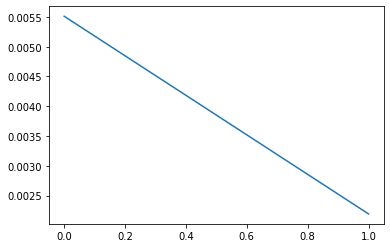

In [21]:
encoder, decoder, _, _ = quick_train(model, train_data_normalized, verbose=True, epochs=2, encoding_dim=7)

In [22]:
with open('/content/drive/MyDrive/Colab Notebooks/LSTM-SAE/encoder4.pickle', mode='wb') as f:
    pickle.dump(encoder, f , protocol=2)
print("モデル4の保存完了です。")

モデル4の保存完了です。


In [23]:
encoder

Encoder(
  (layers): ModuleList(
    (0): LSTM(3, 100, batch_first=True)
    (1): LSTM(100, 10, batch_first=True)
  )
)

In [24]:
model.encoder

Encoder(
  (layers): ModuleList(
    (0): LSTM(3, 100, batch_first=True)
    (1): LSTM(100, 10, batch_first=True)
  )
)

In [25]:
with open('/content/drive/MyDrive/Colab Notebooks/LSTM-SAE/model4.pickle', mode='wb') as f:
    pickle.dump(model, f , protocol=2)
print("モデル42の保存完了です。")

モデル42の保存完了です。
